In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble
from tools.mlr import mlr,maria_IO
from tools.preprocess import do_eof,preproc_maria
#import feature_select
%matplotlib inline
#%matplotlib notebook
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/tmp/ipykernel_3209097/165514747.py:22: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [2]:
def read_mariaradexp(pathprefix=None,expname=None,var=None,suffix=None):
    return [read_and_proc.depickle(pathprefix+lime+suffix)[var][24:120] for lime in expname]

def myPCA_projection_sen(pca_dict=None,varname=None,toproj_flatvar=None,orig_flatvar=None):
    pca_orig = pca_dict[varname].transform(orig_flatvar)
    if pca_dict[varname].mean_ is not None:
        orig_mean = pca_dict[varname].mean_
    projvar_transformed = np.dot(toproj_flatvar-np.nanmean(toproj_flatvar,axis=0),pca_dict[varname].components_.T)
    del orig_mean
    gc.collect()
    return pca_orig, projvar_transformed

class do_radPCcomps:
    def __init__(self,PCAdict=None,basevarname='rad',radvarname=None,nummem=10):
        self.PCAdict=PCAdict
        self.basevarname=basevarname
        self.radvarname=radvarname
        self.nummem = nummem
        self.expname=['ctl','ncrf_36h','ncrf_60h','lwcrf']

    def produce_radcomptimeseries(self,flatvar=None,radflats=None):
        flatvarstemp = [flatvar[expNAME][-1] for expNAME in self.expname]
        basePC = [self.PCAdict['rad'].transform(flatvartempTEMP)[:,0:self.nummem] for flatvartempTEMP in flatvarstemp]
        ts_dict = {}
        for indx,obj in tqdm(enumerate(self.radvarname)):
            radflattemp = radflats[obj]
            temp = [myPCA_projection_sen(pca_dict=self.PCAdict,varname=self.basevarname,toproj_flatvar=radflattemp[i],orig_flatvar=flatvarstemp[0])[1][:,0:self.nummem] for i in range(len(flatvarstemp))]
            ts_dict[obj] = temp
        return ts_dict
    
    def normalize_timeseries_decomp(self,sentimeseries=None,reftimeseries=None,refvarname='rad'):
        ts_dict = {}
        meanstd_dict = {}
        for indx,obj in tqdm(enumerate(self.radvarname)):
            #temp = [ts[obj][expINDEX] for expINDEX in range(len(self.expname))]
            tempf = -np.mean(sentimeseries[obj][0],axis=0)/np.std(reftimeseries[refvarname][0],axis=0)
            ts_dict[obj] = [(sentimeseries[obj][expINDEX]-np.mean(sentimeseries[obj][0],axis=0))/np.std(reftimeseries[refvarname][0],axis=0) for expINDEX in range(len(self.expname))]
            meanstd_dict[obj] = tempf#np.broadcast_to(tempf, (sentimeseries[obj].shape[0], sentimeseries[obj].shape[1]))
        return ts_dict,meanstd_dict
    
    def produce_Qsentimeseries(self,senvar_name=None,refvar_name='rad',numQ=None,flatvar=None,senflatvar=None):
        ts_dict = {}
        temp = [myPCA_projection_sen(pca_dict=self.PCAdict,varname=refvar_name,toproj_flatvar=senflatvar[obj].data,orig_flatvar=flatvar[refvar_name].data)[1][:,0:numQ] for indx,obj in enumerate(senvar_name)]
        return dict(zip(senvar_name,temp))
    
from sklearn.decomposition import IncrementalPCA
def fit_cheap_pca(n_batches=None,n_comps=None,var=None):
    #n_batches = 20
    inc_pca = IncrementalPCA(n_components=n_comps)
    for X_batch in tqdm(np.array_split(var.data,n_batches)):
        inc_pca.partial_fit(X_batch)
    return inc_pca

#### Input

In [4]:
# Basic settings
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/'#preproc/24h_smoo/'
expname = ['ctl','ncrf_36h','ncrf_60h','lwcrf']
varname = ['u','v','w','qv','theta','hdia','rad']
#################################################################################
# Orig model
nummem = [54,26,50,5,75,12,10]
#################################################################################
# 24-hr smoothing model
PCAdict = read_and_proc.depickle('../output/maria/processed/'+'PCA/PCAdict')
# Read files
flatvar = [read_and_proc.depickle(folderpath+'preproc/'+str(expname[i])+'_'+'smooth_preproc_dict1b_g') for i in range(len(expname))]
vardicts = maria_IO.input_output(PCAdict,folderpath,varname,nummem).readvar_separate(listdict=flatvar,varname=['u','v','w','qv','theta','hdia','rad'])
del flatvar#,thetavar
gc.collect()

827

In [5]:
def read_maria(vardicts=None):
    temp1,temp2,temp3,temp4 = vardicts['ctl'],vardicts['ncrf_36h'],vardicts['ncrf_60h'],vardicts['lwcrf']
    mariadata = {}
    for ind,obj in enumerate(['u','v','w','qv','theta','hdia','rad']):
        temp1a,temp2a,temp3a,temp4a = temp1[ind],temp2[ind][36-24-2:],temp3[ind][60-24-2:],temp4[ind][36-24-2:]
        mariadata[obj] = np.concatenate((temp1a,temp2a,temp3a,temp4a),axis=0)
    return mariadata

In [8]:
def _back_to_exp(self,timeseries=None,divider=None):
    printout = [timeseries[0:divider[0],:]]
    for i in range(1,19):
        printout.append(timeseries[divider[i-1]:divider[i],:])
    printout.append(timeseries[divider[-2]:,:])
    return printout
    
def back_to_exp(self,inputlong=None,divider=None,senvarname=None):
    ts_dict = {}
    if senvarname is None:
        for indx,obj in tqdm(enumerate(self.varname)):
            ts_dict[obj] = self._back_to_exp(inputlong[obj],divider)
    else:
        for indx,obj in tqdm(enumerate(senvarname)):
            ts_dict[obj] = self._back_to_exp(inputlong[obj],divider)            
    return ts_dict
    

In [9]:
def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)
    
def myPCA_projection_sen(pca_dict=None,varname=None,toproj_flatvar=None,orig_flatvar=None):
    pca_orig = pca_dict[varname].transform(orig_flatvar)
    if pca_dict[varname].mean_ is not None:
        orig_mean = pca_dict[varname].mean_
    projvar_transformed = np.dot(toproj_flatvar-np.nanmean(toproj_flatvar,axis=0),pca_dict[varname].components_.T)
    del orig_mean
    gc.collect()
    return pca_orig, projvar_transformed

class input_output:
    def __init__(self,PCAdict=None,folderpath=None,ts_varname=None,nummem=None):
        self.PCAdict = PCAdict
        self.varname=ts_varname
        self.nummem = nummem # u: 36 (40% variability in du), v:16/32 (40% dv var;50%), w:44 (40% dw var)
    
    ###################################################################################################################################################
    # Produce time series
    ###################################################################################################################################################    
    def produce_timeseries(self,flatvar=None):
        ts_dict = {}
        for indx,obj in tqdm(enumerate(self.varname)):
            ts_dict[obj] = self.PCAdict[obj].transform(flatvar[obj].data)[:,0:self.nummem[indx]]
        return ts_dict
    
    def produce_Qsentimeseries(self,senvar_name=None,refvar_name='rad',numQ=None,flatvar=None,senflatvar=None):
        ts_dict = {}
        temp = [myPCA_projection_sen(pca_dict=self.PCAdict,varname=refvar_name,toproj_flatvar=senflatvar[obj].data,orig_flatvar=flatvar[refvar_name].data)[1][:,0:numQ] for indx,obj in enumerate(senvar_name)]
        return dict(zip(senvar_name,temp))
    
    def normalize_timeseries(self,timeseries=None):
        assert timeseries['u'].shape[-1]==self.nummem[0],"var shape error"
        ts_dict = {}
        for indx,obj in tqdm(enumerate(self.varname)):
            ts_dict[obj] = (timeseries[obj]-np.nanmean(timeseries[obj],axis=0))/np.nanstd(timeseries[obj],axis=0)
        return ts_dict
    
    def normalize_timeseries_decomp(self,sentimeseries=None,reftimeseries=None,senvarnames=None,refvarname='rad'):
        ts_dict = {}
        meanstd_dict = {}
        for indx,obj in tqdm(enumerate(senvarnames)):
            tempf = -np.mean(sentimeseries[obj],axis=0)/np.std(reftimeseries[refvarname],axis=0)
            ts_dict[obj] = (sentimeseries[obj]-np.mean(sentimeseries[obj],axis=0))/np.std(reftimeseries[refvarname],axis=0)
            meanstd_dict[obj] = np.broadcast_to(tempf, (sentimeseries[obj].shape[0], sentimeseries[obj].shape[1]))
        return ts_dict,meanstd_dict
    
    ###################################################################################################################################################
    # Produce Input Dataset
    ###################################################################################################################################################      
    def _back_to_exp(self,timeseries=None,divider=None):
        printout = [timeseries[0:divider[0],:]]
        for i in range(1,len(divider)-1):
            printout.append(timeseries[divider[i-1]:divider[i],:])
        printout.append(timeseries[divider[-2]:,:])
        return printout
    
    def back_to_exp(self,inputlong=None,divider=None,senvarname=None):
        ts_dict = {}
        if senvarname is None:
            for indx,obj in tqdm(enumerate(self.varname)):
                ts_dict[obj] = self._back_to_exp(inputlong[obj],divider)
        else:
            for indx,obj in tqdm(enumerate(senvarname)):
                ts_dict[obj] = self._back_to_exp(inputlong[obj],divider)            
        return ts_dict
    
    def make_X(self,expvarlist=None,varwant=None):
        trainlist = []
        for obj in varwant:
            test1 = np.concatenate([expvarlist[obj][i] for i in range(len(expvarlist[obj]))],axis=0)
            trainlist.append(test1)
        return np.concatenate([trainlist[i] for i in range(len(trainlist))],axis=1)
    
    ###################################################################################################################################################
    # Produce Output Dataset
    ###################################################################################################################################################
    def get_time_diff_terms(self,inputvar=None,LT=None):
        def _get_time_diff(array=None,timedelta=60*60,LT=None):
            store = []
            for exp in array:
                a = forward_diff(exp,timedelta,0,LT)
                if a.shape[0]>0:
                    azero = np.zeros((LT,exp.shape[-1]))
                    store.append(np.concatenate((a,azero),axis=0))
                else:
                    store.append(np.zeros((exp.shape[0],exp.shape[-1])))
            return store
        
        storedict = {}
        for wantvar in ['u','v','w','theta']:
            storedict[wantvar] = _get_time_diff(array=inputvar[wantvar],LT=LT)
        return storedict
    
    def make_Y(self,inputdict=None,LDT=None):
        def _make_Y(inputt=None):
            varTRAIN = []
            for varobj in ['u','v','w','theta']:
                test1 = inputt[varobj]
                varTRAIN.append(np.concatenate([test1[indx] for indx in range(len(test1))],axis=0))
            return np.concatenate([varTRAIN[i] for i in range(len(varTRAIN))],axis=1)
        test = [self.get_time_diff_terms(inputdict,int(LDTobj)) for LDTobj in LDT]
        return [_make_Y(timediffobj) for timediffobj in test]

In [6]:
maria_data = read_maria(vardicts)

#### Train PCA

In [7]:
radpca = fit_cheap_pca(n_batches=5,n_comps=30,var=maria_data['rad'])
hdiapca = fit_cheap_pca(n_batches=5,n_comps=30,var=maria_data['hdia'])
upca = fit_cheap_pca(n_batches=5,n_comps=60,var=maria_data['u'])
vpca = fit_cheap_pca(n_batches=5,n_comps=40,var=maria_data['v'])
wpca = fit_cheap_pca(n_batches=5,n_comps=60,var=maria_data['w'])
qvpca = fit_cheap_pca(n_batches=5,n_comps=15,var=maria_data['qv'])
thetapca = fit_cheap_pca(n_batches=3,n_comps=80,var=maria_data['theta'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:13<00:00, 98.62s/it]


In [9]:
PCAdictN = {'u':upca,'v':vpca,'w':wpca,'qv':qvpca,'theta':thetapca,'rad':radpca,'hdia':hdiapca}

folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/maria/processed/PCA'
expname = 'PCAdict'
read_and_proc.save_to_pickle(folderpath+'/'+str(expname),PCAdictN,'PICKLE')

#### RAD terms

In [7]:
# Rad
raddict = {}
for var in ['LW','SW','LWC','SWC','IRLW','IRSW']:
    temp = read_mariaradexp('../output/maria/processed/',['ctl','ncrf_36h','ncrf_60h','lwcrf'],var=var,suffix='_preproc_dict1_g_rads')
    raddict[var] = np.concatenate((temp[0],temp[1][36-24-2:],temp[2][60-24-2:],temp[3][36-24-2:]),axis=0)

In [12]:
radtest = PCAdictN['rad'].transform(maria_data['rad'])

In [14]:
irlw,irsw = np.dot(raddict['IRLW']-np.nanmean(raddict['IRLW'],axis=0),PCAdictN['rad'].components_.T),np.dot(raddict['IRSW']-np.nanmean(raddict['IRSW'],axis=0),PCAdictN['rad'].components_.T)
lwc,swc = np.dot(raddict['LWC']-np.nanmean(raddict['LWC'],axis=0),PCAdictN['rad'].components_.T),np.dot(raddict['SWC']-np.nanmean(raddict['SWC'],axis=0),PCAdictN['rad'].components_.T)

#### Input

In [27]:
nummem=[54,26,50,5,75,12,10]
maria_pca_nonorml = input_output( PCAdictN, None, ['u', 'v', 'w', 'qv', 'theta', 'hdia', 'rad'], nummem ).produce_timeseries( maria_data )
maria_pca_norml = input_output( PCAdictN, None, ['u', 'v', 'w', 'qv', 'theta', 'hdia', 'rad'], nummem ).normalize_timeseries( maria_pca_nonorml )

7it [00:40,  5.81s/it]


In [48]:
divider = np.asarray([96,86,62,86]).cumsum()
exp_pca_norml = input_output( PCAdictN, None, ['u', 'v', 'w', 'qv', 'theta', 'hdia', 'rad'], nummem ).back_to_exp( maria_pca_norml, divider ) 
exp_pca_nonorml = input_output( PCAdictN, None, ['u', 'v', 'w', 'qv', 'theta', 'hdia', 'rad'], nummem ).back_to_exp( maria_pca_nonorml, divider ) 

7it [00:00, 85349.21it/s]
7it [00:00, 91750.40it/s]


In [54]:
EXP = [['hdia','rad'],['theta','hdia','rad'],['u','v','w','theta','hdia','rad'],['u','v','theta','hdia','rad'],['u','v'],['u','v','w'],['u','v','hdia','rad'],['u','v','w','hdia','rad'],['u','v','w','theta','qv','hdia','rad']]
storename = ['dt','dtth','dtthuvw','dtthuv','uv','uvw','dtuv','dtuvw','dtthuvwqv']

X_traindict = {}
for ind,obj in enumerate(storename):
    test1 = (input_output(PCAdictN,None,['u', 'v', 'w', 'qv', 'theta', 'hdia', 'rad'],nummem).make_X(exp_pca_norml,EXP[ind]))
    X_traindict[obj] = test1

In [76]:
y_all = (input_output(PCAdictN,None,['u', 'v', 'w', 'qv', 'theta', 'hdia', 'rad'],nummem).make_Y(exp_pca_nonorml,np.linspace(0,35,36)+1))

In [79]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/maria/processed/inputoutput'
expname = 'inputQ95_dict_new'
read_and_proc.save_to_pickle(folderpath+'/'+str(expname)+'_'+'smoo6_withtheta',X_traindict,'PICKLE')
expname = 'outputQ95_dict_new'
read_and_proc.save_to_pickle(folderpath+'/'+str(expname)+'_'+'smoo6_withtheta',y_all,'PICKLE')

#### Radiative heating

In [11]:
nummem=[54,26,50,5,75,12,10]
maria_pca_nonorml = input_output( PCAdict, None, ['rad'], nummem ).produce_Qsentimeseries(['LW','SW','LWC','SWC','IRLW','IRSW'],'rad',10,maria_data,raddict)
maria_pca_nonorml_rad = input_output( PCAdict, None, ['rad'], [10] ).produce_timeseries( maria_data )

1it [00:04,  4.56s/it]


In [13]:
swlw_dict,lwcswcir_dict = {k:v for k,v in maria_pca_nonorml.items() if k in ['LW','SW']},{k:v for k,v in maria_pca_nonorml.items() if k in ['LWC','SWC','IRLW','IRSW']}
swlw_decomp_norml,swlwMEAN_decomp_norml = input_output( PCAdict, None, ['rad'], [20] ).normalize_timeseries_decomp(swlw_dict,maria_pca_nonorml_rad,['LW','SW'],'rad')
lwcswcir_decomp_norml,lwcswcirMEAN_decomp_norml = input_output( PCAdict, None, ['rad'], [20] ).normalize_timeseries_decomp(lwcswcir_dict,maria_pca_nonorml_rad,['LWC','SWC','IRLW','IRSW'],'rad')
#exp_pca_norml_swlw,exp_pca_norml_swlwMEAN = input_output(dict1,None,['rad'],[20]).back_to_exp(swlw_decomp_norml,divider,['LW','SW']),input_output(dict1,None,['rad'],[20]).back_to_exp(swlwMEAN_decomp_norml,divider,['LW','SW'])
#exp_pca_norml_lwcswcir,exp_pca_norml_lwcswcirMEAN = input_output(dict1,None,['rad'],[20]).back_to_exp(lwcswcir_decomp_norml,divider,['LWC', 'SWC', 'IRLW', 'IRSW']),input_output(dict1,None,['rad'],[20]).back_to_exp(swlwMEAN_decomp_norml,divider,['LW','SW'])

2it [00:00, 2959.99it/s]
4it [00:00, 5279.17it/s]


In [14]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/maria/processed/'
read_and_proc.save_to_pickle(folderpath+'radcomp/SWLW'+'_'+'dict_g',swlw_decomp_norml,'PICKLE')
read_and_proc.save_to_pickle(folderpath+'radcomp/LWCSWCIR'+'_'+'dict_g',lwcswcir_decomp_norml,'PICKLE')
read_and_proc.save_to_pickle(folderpath+'radcomp/SWLW_MEAN'+'_'+'dict_g',swlwMEAN_decomp_norml,'PICKLE')
read_and_proc.save_to_pickle(folderpath+'radcomp/LWCSWCIR_MEAN'+'_'+'dict_g',lwcswcirMEAN_decomp_norml,'PICKLE')

In [16]:
TESTR = raddict['IRLW'].reshape(330,39,360,167)

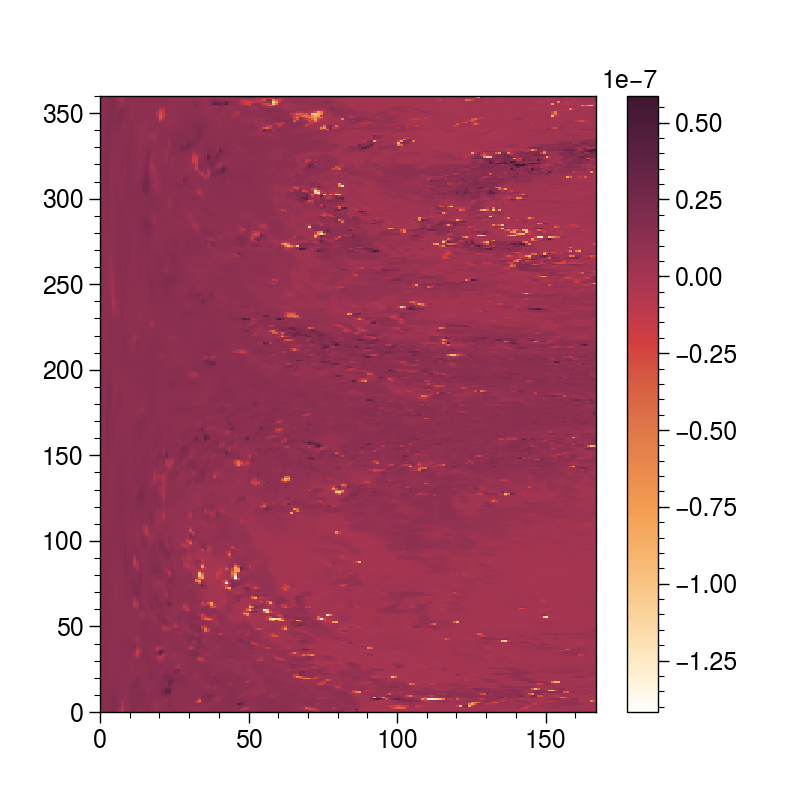

In [48]:
#np.nonzero(TESTR[96+24,8,:,:])
plt.pcolormesh(TESTR[96+12,8,:,:])
plt.colorbar()
plt.show()

In [44]:
np.nonzero(TESTR[96+24,8,:,:])

(array([], dtype=int64), array([], dtype=int64))

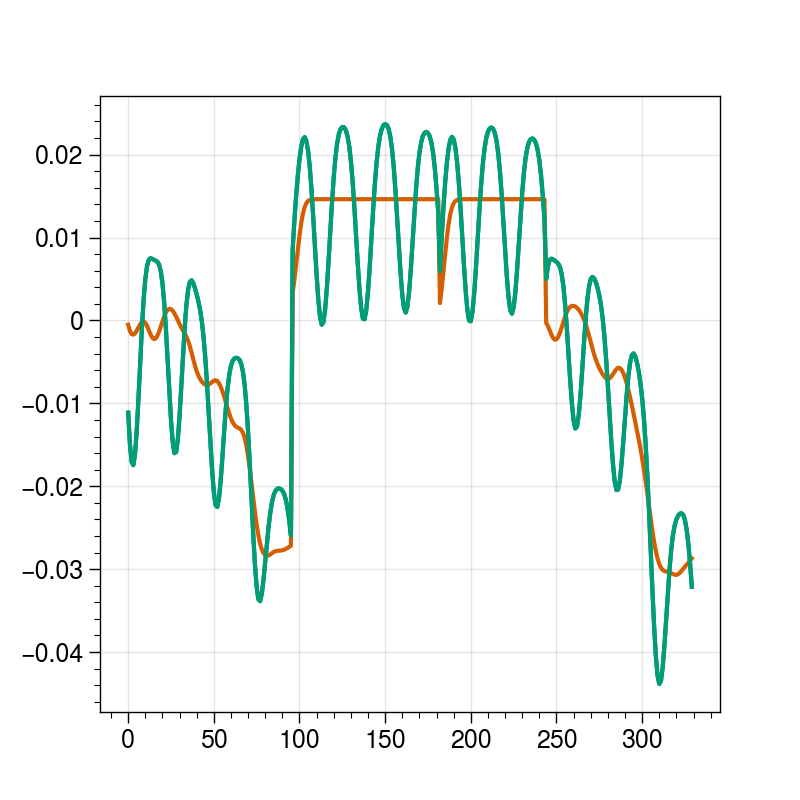

In [31]:
plt.plot(maria_pca_nonorml['IRLW'][:,0]+maria_pca_nonorml['IRSW'][:,0]+maria_pca_nonorml['LWC'][:,0]+maria_pca_nonorml['SWC'][:,0])
plt.plot(maria_pca_nonorml['IRLW'][:,0])
plt.plot(maria_pca_nonorml_rad['rad'][:,0])
plt.show()

In [59]:
np.dot(raddict['IRLW'][120:160]-np.nanmean(raddict['IRLW'][120:160],axis=0),PCAdict['rad'].components_.T)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

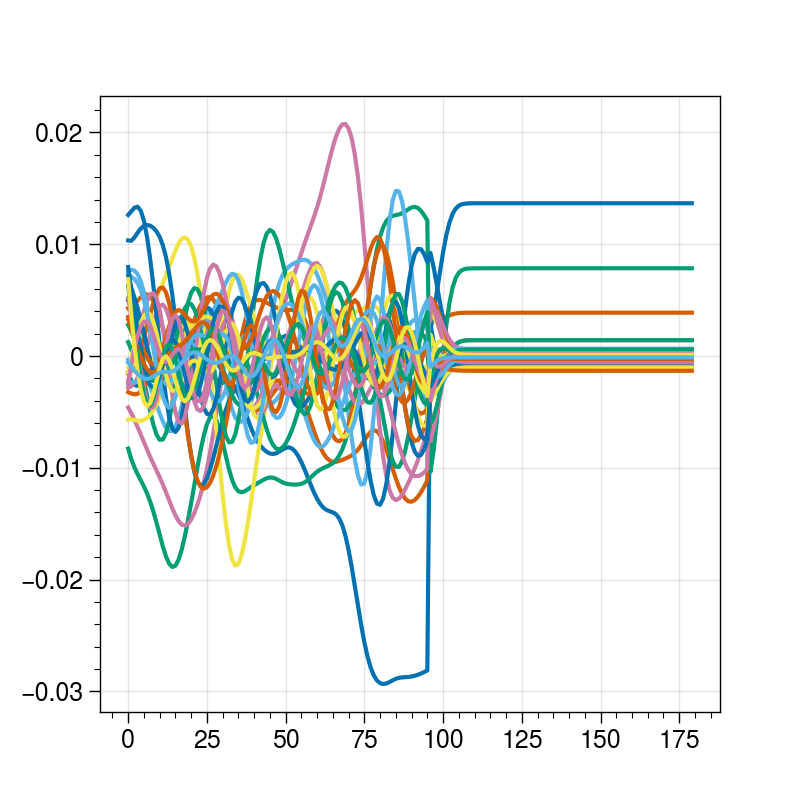

In [77]:
plt.plot(np.dot(raddict['IRLW'][0:96+84]-np.nanmean(raddict['IRLW'][0:96+84],axis=0),PCAdict['rad'].components_.T))
#plt.xlim(20,40)
#plt.ylim(-0.0001,0.0001)
plt.show()